In [290]:
from muzero.networks import MuZeroNetwork
from muzero.context import MuZeroContext
import gymnasium
import ale_py
from pandas import Timestamp
import numpy as np
import matplotlib.pyplot as plt
from muzero.game import Node
from muzero.tree_search import expand_node, run_mcts

output_path = f'../outputs/DQN/{int(Timestamp.now().timestamp())}'

gymnasium.register_envs(ale_py)

env = gymnasium.wrappers.AtariPreprocessing(
        gymnasium.wrappers.RecordVideo(
            gymnasium.make("ALE/MsPacman-v5", render_mode="rgb_array", frameskip=4),
            f"test",
            lambda x: True,
        ),
        screen_size=96,
        grayscale_obs=False,
        frame_skip=1,
    )
network : MuZeroNetwork = MuZeroNetwork.from_checkpoint('../checkpoints/muzero_fixed_priorities').to('cpu')

p:\MINI8\RL\reinforcement-learning\venv\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at p:\MINI8\RL\reinforcement-learning\scripts\test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [593]:
context = MuZeroContext(
    n_actions=9,
    max_moves=27000,  # Half an hour at action repeat 4.
    discount=0.997,
    dirichlet_alpha=0.25,
    num_simulations=10,
    batch_size=256,
    td_steps=5,
    num_actors=1,
    lr_init=0.05,
    lr_decay_steps=350e3,
    value_loss_weight=0.25,
    env_factory=lambda _: env,
    checkpoint_path=""
)

In [292]:
def select_action_with_temperature(temperature: float, node):
    visit_counts = np.array(
        [child.visit_count for child in node.children.values()], dtype="int32"
    )
    actions = [action for action in node.children.keys()]

    if temperature == 0:
        action = actions[np.argmax(visit_counts)]
    elif temperature == float("inf"):
        action = np.random.choice(actions)
    else:
        visit_count_distribution = visit_counts ** (1 / temperature)
        visit_count_distribution = visit_count_distribution / sum(
            visit_count_distribution
        )
        action = np.random.choice(actions, p=visit_count_distribution)

    return action

In [429]:
game = context.new_game(0)

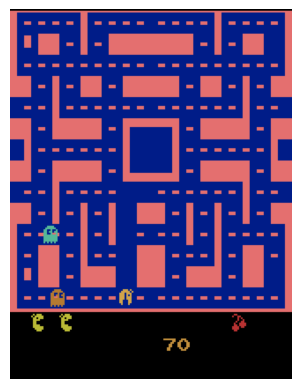

[(0, 0, 0, 0),
 (1, 0, 0, 0),
 (2, 0, 0, 0),
 (3, 0, 0, 0),
 (4, 7, 22.62664742051458, 0.0015245676040649414),
 (5, 0, 0, 0),
 (6, 0, 0, 0),
 (7, 3, 25.0088631504844, 0.0018824338912963867),
 (8, 0, 0, 0)]

In [596]:
from muzero.tree_search import add_exploration_noise


state = game.get_state(len(game.states), 32, 32)
hidden_state, policy_logits, initial_reward, value_logits = network.initial_inference(state)

root = Node(0)
expand_node(root, hidden_state, policy_logits, 0)

run_mcts(context, root, [], network)
add_exploration_noise(context.root_dirichlet_alpha, context.root_exploration_fraction, root)
action = select_action_with_temperature(0.0, root)
game.apply_action(action)

# Render the environment and get the image
image = env.render()

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

[(child_key, child.visit_count, child.value(), child.reward) for child_key, child in root.children.items()]

In [542]:
# Function to search the whole tree for the node with the highest reward
def find_highest_value_node(node):
    max_reward = 0
    best_node = node

    def dfs(current_node):
        nonlocal max_reward, best_node
        if current_node.value() > max_reward:
            max_reward = current_node.reward
            best_node = current_node
        for child in current_node.children.values():
            dfs(child)

    dfs(node)
    return best_node

# Find the node with the highest reward in the whole tree
best_node = find_highest_value_node(root)
print(f"Node with highest reward: {best_node}, Reward: {best_node.reward}")

Node with highest reward: <muzero.game.Node object at 0x00000245CBABD7B0>, Reward: 0.004628777503967285


In [289]:
from tqdm import tqdm

game = context.new_game(0)

with tqdm() as p_bar:
    while not game.done:
        state = game.get_state(len(game.states), 32, 32)
        hidden_state, policy_logits, initial_reward, value_logits = network.initial_inference(state)

        root = Node(0)
        expand_node(root, hidden_state, policy_logits, initial_reward)

        run_mcts(context, root, [], network)
        action = select_action_with_temperature(1.0, root)
        game.apply_action(action)
        p_bar.update(1)

game.env.reset()

376it [00:46,  8.13it/s]


(array([[[124,  60,  60],
         [124,  60,  60],
         [112,  56,  62],
         ...,
         [112,  56,  62],
         [124,  60,  60],
         [124,  60,  60]],
 
        [[228, 111, 111],
         [228, 111, 111],
         [ 91,  61, 126],
         ...,
         [ 91,  61, 126],
         [228, 111, 111],
         [228, 111, 111]],
 
        [[228, 111, 111],
         [228, 111, 111],
         [ 91,  61, 126],
         ...,
         [ 91,  61, 126],
         [228, 111, 111],
         [228, 111, 111]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
  